In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import PIL
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from IPython.display import Image
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader
import os
from collections import namedtuple
from torch.optim import Adam
import numpy as np
import glob
import torchvision.models as models
import random

import copy



In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_dir = "dataset"
train_data = torchvision.datasets.ImageFolder(os.path.join(train_dir))

In [4]:
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

In [5]:
dataset = datasets.ImageFolder("E:/UNH/Sem3/DL/Pro/Multi-Style-Transfer/dataset", transform=transform)

In [6]:
len(train_data)

123287

In [7]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

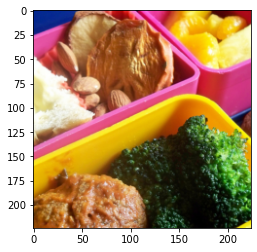

In [8]:
images, labels = next(iter(dataloader))
sample = images[0]
# Image(images[0], normalize=False)
plt.imshow(images[0].permute(1, 2, 0))

In [25]:
def gram_matrix(y):
    (b, c, h, w) = y.size()
    features = y.view(b, c, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (c * h * w)
    return gram

In [27]:
def train_transform(image_size):
    transform = transforms.Compose(
        [
            transforms.Resize(int(image_size * 1.15)),
            transforms.RandomCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    )
    return transform

In [28]:
def style_transform(image_size=None):
    resize = [transforms.Resize(image_size)] if image_size else []
    transform = transforms.Compose(resize + [transforms.ToTensor(), transforms.Normalize(mean, std)])
    return transform

# Ref - https://towardsdatascience.com/towards-fast-neural-style-transfer-191012b86284

In [31]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
# as per vgg16 model

In [21]:
class VGG16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(VGG16, self).__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ["relu1_2", "relu2_2", "relu3_3", "relu4_3"]) # using parallel data
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out

In [22]:
class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        self.model = nn.Sequential(
            ConvBlock(3, 32, kernel_size=9, stride=1),
            ConvBlock(32, 64, kernel_size=3, stride=2),
            ConvBlock(64, 128, kernel_size=3, stride=2),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ConvBlock(128, 64, kernel_size=3, upsample=True),
            ConvBlock(64, 32, kernel_size=3, upsample=True),
            ConvBlock(32, 3, kernel_size=9, stride=1, normalize=False, relu=False),
        )

    def forward(self, x):
        return self.model(x)

In [23]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=True),
            ConvBlock(channels, channels, kernel_size=3, stride=1, normalize=True, relu=False),
        )

    def forward(self, x):
        return self.block(x) + x

In [24]:

class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, upsample=False, normalize=True, relu=True):
        super(ConvBlock, self).__init__()
        self.upsample = upsample
        self.block = nn.Sequential(
            nn.ReflectionPad2d(kernel_size // 2), nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        )
        self.norm = nn.InstanceNorm2d(out_channels, affine=True) if normalize else None
        self.relu = relu

    def forward(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2)
        x = self.block(x)
        if self.norm is not None:
            x = self.norm(x)
        if self.relu:
            x = F.relu(x)
        return x


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = datasets.ImageFolder("E:/UNH/Sem3/DL/Pro/Multi-Style-Transfer/dataset", train_transform(254))
dataloader = DataLoader(train_dataset, batch_size=32)

#Defining networks
transformer = TransformerNet().to(device)
vgg = VGG16(requires_grad=False).to(device)

In [41]:
optimizer = Adam(transformer.parameters(), 1e-3)
l2_loss = torch.nn.MSELoss().to(device)

In [59]:
# Load style image
style = style_transform(254)(PIL.Image.open("dancing.jpg").convert('RGB'))
style = style.repeat(32, 1, 1, 1).to(device)

In [65]:
# Extract style features
features_style = vgg(style)
gram_style = [gram_matrix(y) for y in features_style]

In [80]:
for epoch in range(1):
        epoch_metrics = {"content": [], "style": [], "total": []}
        for batch_i, (images, _) in enumerate(dataloader):
            optimizer.zero_grad()

            images_original = images.to(device)
            images_transformed = transformer(images_original)

            # Extract features
            features_original = vgg(images_original)
            features_transformed = vgg(images_transformed)

            # Compute content loss as MSE between features
            content_loss = args.lambda_content * l2_loss(features_transformed.relu2_2, features_original.relu2_2)

            # Compute style loss as MSE between gram matrices
            style_loss = 0
            for ft_y, gm_s in zip(features_transformed, gram_style):
                gm_y = gram_matrix(ft_y)
                style_loss += l2_loss(gm_y, gm_s[: images.size(0), :, :])
            style_loss *= args.lambda_style

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            epoch_metrics["content"] += [content_loss.item()]
            epoch_metrics["style"] += [style_loss.item()]
            epoch_metrics["total"] += [total_loss.item()]


            batches_done = epoch * len(dataloader) + batch_i + 1
            if batches_done % args.sample_interval == 0:
                save_sample(batches_done)


RuntimeError: CUDA out of memory. Tried to allocate 254.00 MiB (GPU 0; 4.00 GiB total capacity; 2.84 GiB already allocated; 10.39 MiB free; 2.90 GiB reserved in total by PyTorch)